!pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [1]:
# Lib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [2]:
# Load the time series data
df = pd.read_csv("../epidemic_curve.csv")
df.head()


,date,cases
0,2024-01-01,0
1,2024-01-08,0
2,2024-01-15,46
3,2024-01-22,40
4,2024-01-29,3


In [3]:
df["date"] = pd.to_datetime(df["date"])

In [4]:
# give the row index for 2024-05-27
target_date = "2024-05-27"
split_idx = df[df["date"] == target_date].index[0]


#### Use data before 2024-05-27 date for context (i.e., training)

In [5]:
# Prepare the data for Chronos
'''
Extract the numeric series (the cases column) and convert it to a PyTorch tensor. 

Chronos expects a 1D tensor (or a batch of 1D tensors) as input.
'''
train_data = df["cases"].iloc[:split_idx + 1]  # include the week of 2024-05-27

context=torch.tensor(train_data.values, dtype=torch.float32)

In [6]:
context.shape # This creates context, a 1D tensor of length 40 (for 40 weeks)

torch.Size([22])

In [7]:
# Load the pre-trained Chronos model
'''
Use ChronosPipeline.from_pretrained to load the Chronos-T5 model.

The resulting pipeline object encapsulates the model and will be used for prediction.
'''
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="mps") # This will download the amazon/chronos-t5-small model and initialize a forecasting pipeline
# Also i can use device_map="auto" to use GPU if available or device_map="mps" for my MacBook laptop

'''
We can switch to chronos-t5-large or any other model just by changing the model name.
For example:
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="mps")
                (or)
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base", device_map="mps")
                (or)
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="mps")
                ...

                
'''


'\nWe can switch to chronos-t5-large or any other model just by changing the model name.\nFor example:\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="mps")\n                (or)\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base", device_map="mps")\n                (or)\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="mps")\n                ...\n\n\n'

#### Forecast the next 4 weeks

In [8]:
# Forecast the next 4 weeks
'''
Call pipeline.predict with the context tensor and prediction_length=4 to forecast the next 4 time steps.
'''

prediction_length = 4 # We want to forecast the next 4 weeks
forecast = pipeline.predict(context, prediction_length) # shape [num_series, num_samples, prediction_length]


In [9]:
forecast.shape # This creates forecast, a 1D tensor of length 4 (for 4 predicted weeks)

torch.Size([1, 20, 4])

This runs the model to predict 4 future weekly values. Internally, Chronos generates many sample trajectories; as shown above, the output forecast will have shape `[num_series, num_samples, prediction_length]`. 

Here **num_series=1 (one time series)** and **prediction_length=4**. 

For example, if the default num_samples is 20, then forecast.shape would be (1, 20, 4).

In [10]:
forecast[0] # (shape [num_samples, 4]) to see all sampled forecasts. The predicted values for the next 4 weeks

tensor([[1747.2440, 1527.2207, 1315.8258, 1009.5188],
        [1786.0717, 1665.2745, 1600.5618, 1617.8185],
        [1578.9910, 1264.0557,  884.4075,  444.3608],
        [1639.3894, 1294.2549,  858.5224,  556.5296],
        [1734.3015, 1488.3931, 1259.7415, 1069.9174],
        [1600.5618, 1186.4003,  698.8976,  379.6481],
        [1639.3894, 1251.1130,  871.4649,  582.4147],
        [1656.6461, 1255.4272,  703.2118,  211.3950],
        [1643.7036, 1246.7990,  845.5798,  422.7899],
        [1721.3590, 1514.2781, 1251.1130,  983.6337],
        [1596.2477, 1095.8024,  582.4147,  323.5637],
        [1578.9910, 1177.7719,  707.5260,  414.1615],
        [1682.5312, 1311.5116,  845.5798,  414.1615],
        [1626.4469, 1147.5726,  733.4111,  340.8204],
        [1764.5007, 1509.9640, 1169.1436,  776.5529],
        [1773.1292, 1509.9640, 1216.5995,  776.5529],
        [1747.2440, 1604.8760, 1527.2207, 1479.7646],
        [1635.0752, 1341.7108, 1082.8599,  759.2961],
        [1660.9603, 1341.710

In [11]:
# Chronos produces a distribution of future values
# Visualize the forecast

#forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

print("Low (10th percentile) forecast for next 4 weeks:", low)
print("Median (50th percentile) forecast for next 4 weeks:", median)
print("High (90th percentile) forecast for next 4 weeks:", high)


Low (10th percentile) forecast for next 4 weeks: [1594.52200928 1174.75192871  702.7803772   339.09476318]
Median (50th percentile) forecast for next 4 weeks: [1650.17486572 1302.88323975  877.93618774  569.47213745]
High (90th percentile) forecast for next 4 weeks: [1765.36357422 1534.98623047 1336.96529541 1110.9020874 ]


#### Create forecast dates starting from the week after 2024-05-27

In [12]:
start_date = pd.to_datetime("2024-06-03")  # week after May 27
forecast_dates = pd.date_range(start=start_date, periods=4, freq="W-MON")


In [13]:
# Print forecasted 4 weeks with dates
print("\nForecasted Cases (Next 4 Weeks after 2024-05-27):")
for d, c in zip(forecast_dates, median):
    print(f"{d.strftime('%Y-%m-%d')}: {round(c, 2)} cases")


Forecasted Cases (Next 4 Weeks after 2024-05-27):
2024-06-03: 1650.17 cases
2024-06-10: 1302.88 cases
2024-06-17: 877.94 cases
2024-06-24: 569.47 cases


####  Plot the historical data and the forecast

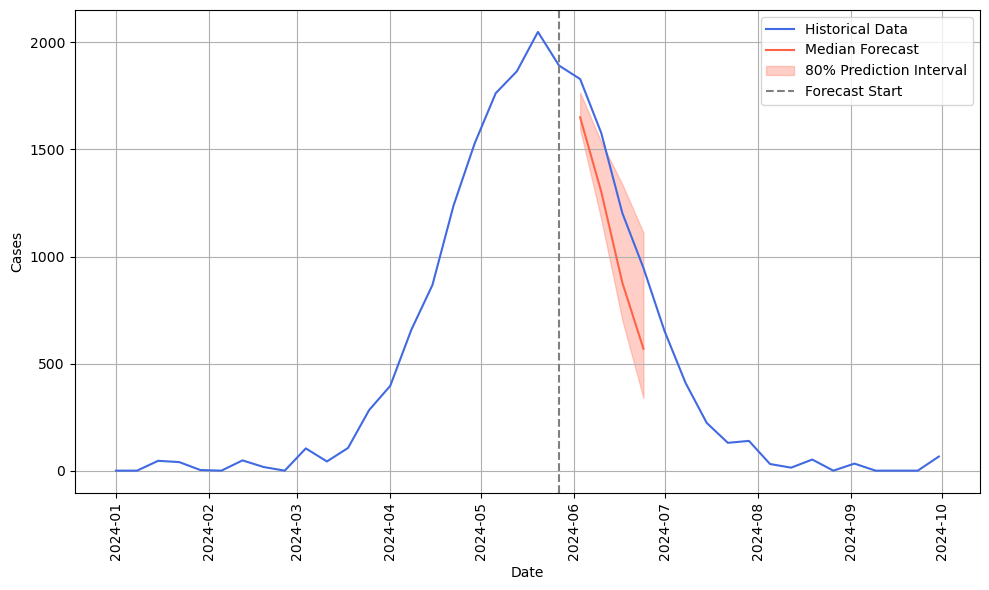

In [14]:
# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["cases"], color="royalblue", label="Historical Data")
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

# Add vertical line to indicate the start of the forecast
plt.axvline(pd.to_datetime("2024-05-27"), color="gray", linestyle="--", label="Forecast Start")

plt.xlabel("Date")
plt.xticks(rotation=90)

plt.ylabel("Cases")

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluate Chronos with MAE, RMSE, $R^2$

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1. We already have split_idx from before but again for clarity
target_date = "2024-05-27"
split_idx = df[df["date"] == target_date].index[0]

# Step 2. Create train/test split based on that index
train_data = df["cases"].iloc[:split_idx + 1]  # includes 2024-05-27
test_data = df["cases"].iloc[split_idx + 1 : split_idx + 1 + prediction_length]

# Step3. Prepare context
context_train = torch.tensor(train_data.values, dtype=torch.float32)

# Step 4. Forecast
forecast = pipeline.predict(context_train, prediction_length=prediction_length)
median_forecast = np.quantile(forecast[0].numpy(), 0.5, axis=0)

# Step 5. Evaluate
y_true = test_data.values
y_pred = median_forecast

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_true, y_pred)

In [16]:
# Step 6: Print results
print("Evaluation on 4 Weeks After 2024-05-27")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

Evaluation on 4 Weeks After 2024-05-27
MAE:  218.78
RMSE: 231.07
R²:   0.53


In [17]:
print("GPU available:", torch.cuda.is_available())

GPU available: False
